# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
dataset_url = "Wholesale-customers-data.csv"
df = pd.read_csv(dataset_url)
df.shape

(440, 8)

In [3]:
df.head()

# notiamo che le feature hanno ordini di grandezza molto diversi
# questo è un problema nel clustering dato che è un metodo basato su distanze
# Sarà necessario normalizzare i dati in maniera tale da permettere ad ogni 
# feature di poter influenzare la distanza in maniera equa 
# (magari alcune feature verranno considerate irrilevanti una volta applicato
# l'algoritmo di clustering, ma questo non lo possiamo sapere a priori)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Observe the data distributions

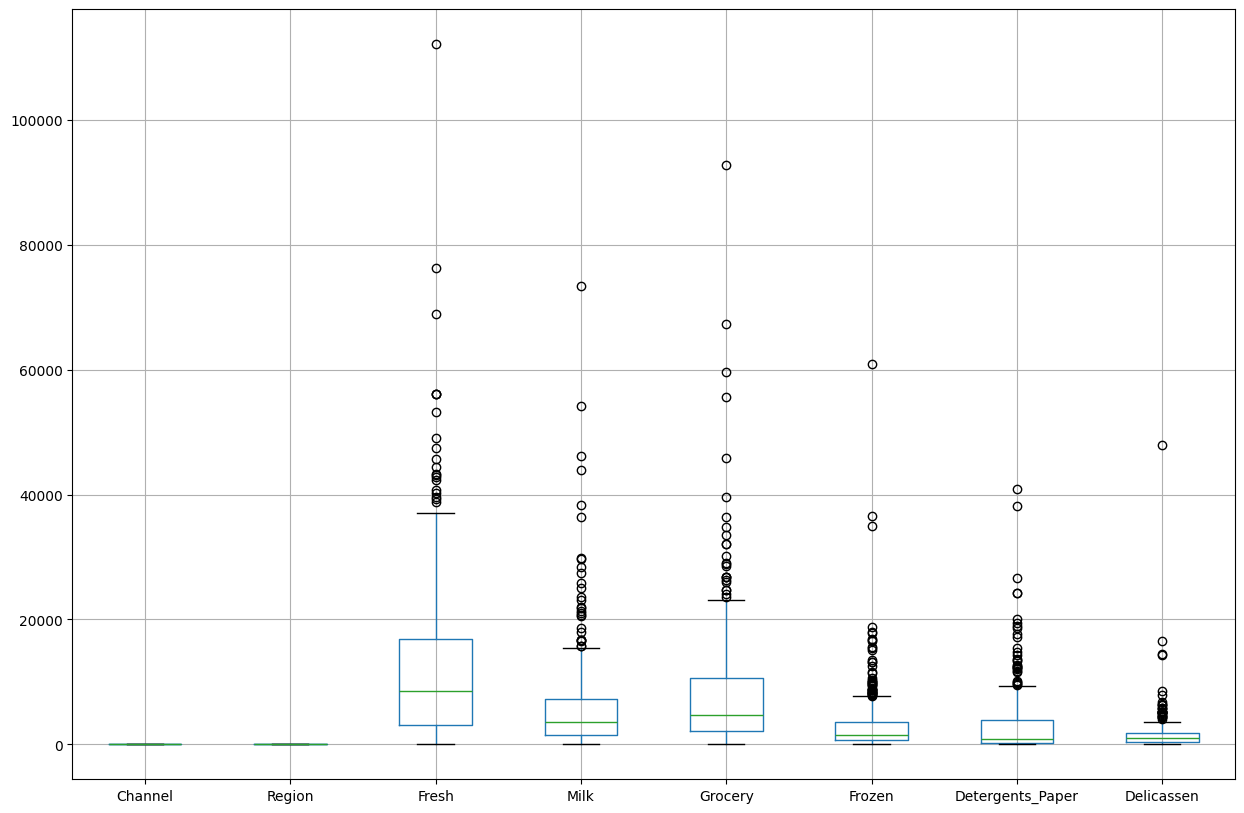

In [4]:
plt.figure(figsize=(15, 10))
df.boxplot()
plt.show()

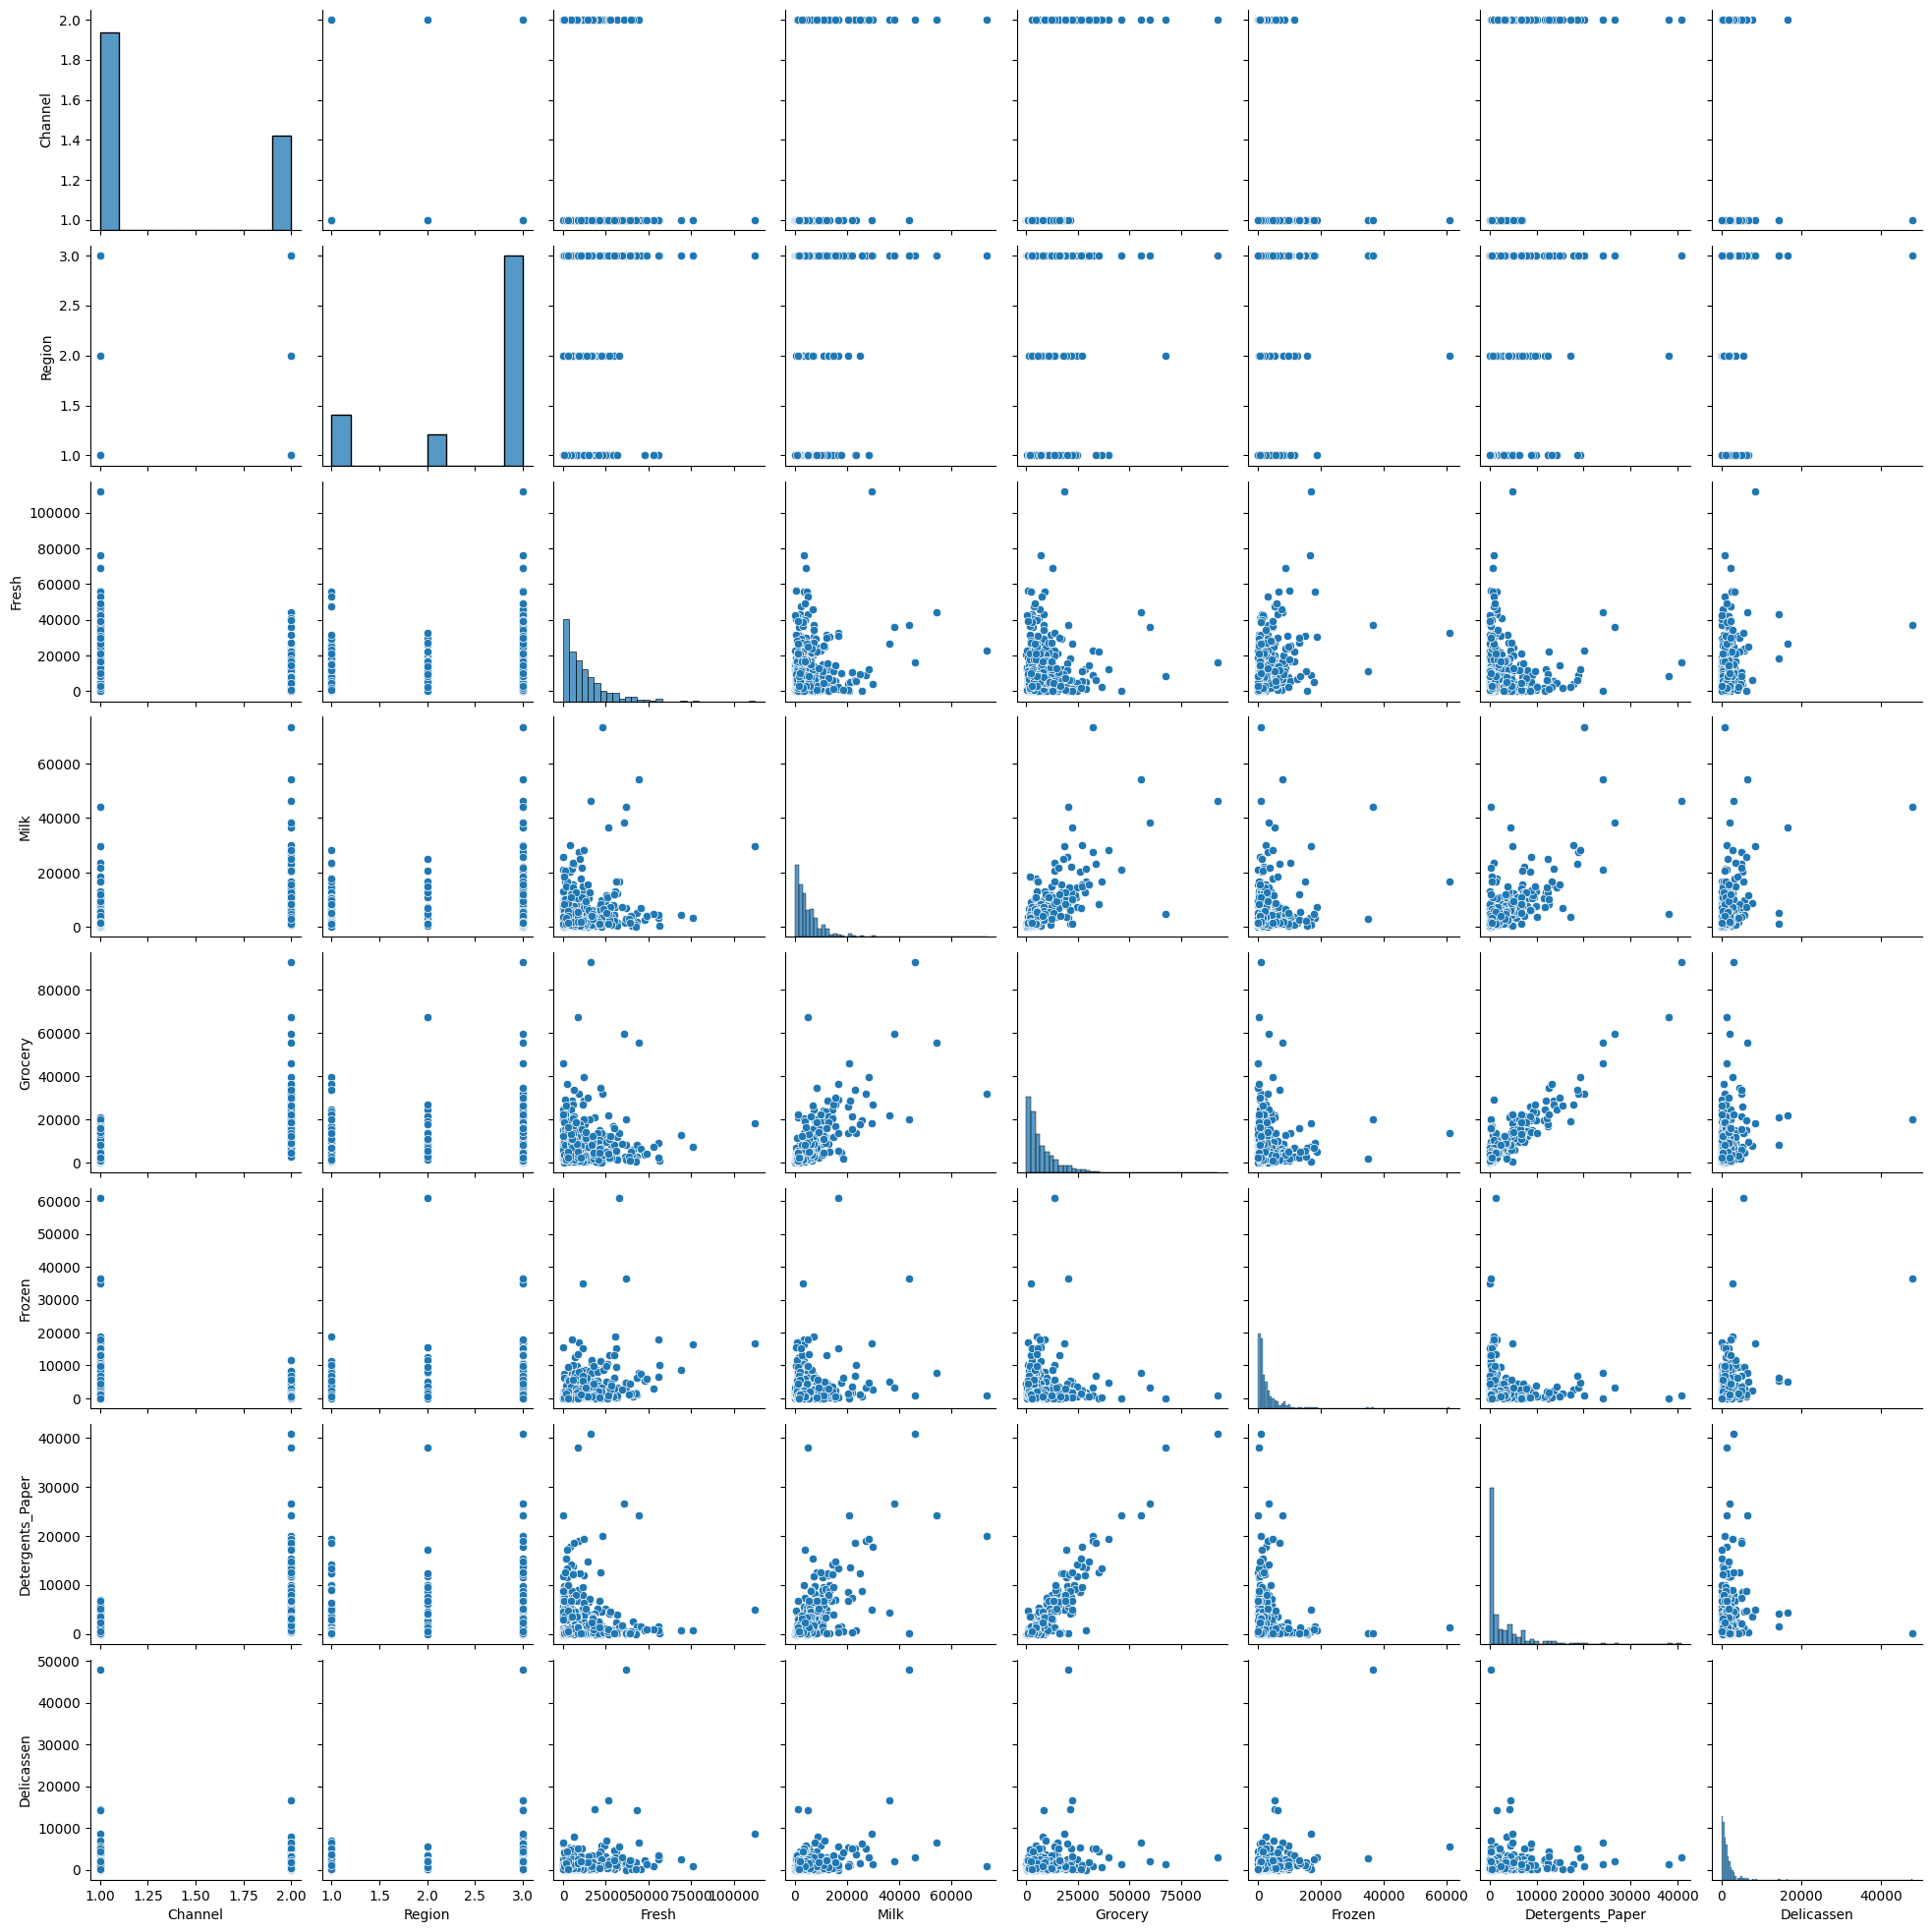

In [5]:
sns.pairplot(df)
plt.show()

In [6]:
# corr = df.corr()
# plt.figure(figsize=(15,10))
# sns.heatmap(corr,cmap='YlGnBu', annot=True)
# plt.show()

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1` with `MinMaxScaler`

In [7]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

dataset_url = "Wholesale-customers-data.csv"
df = pd.read_csv(dataset_url)

old_df = df.copy()
print(old_df.head())

pt = PowerTransformer()
df[df.columns[2:]] = pt.fit_transform(df[df.columns[2:]])
print(df.head())

scaler = MinMaxScaler(feature_range=(0, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()


   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
   Channel  Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0        2       3  0.413012  0.979454  0.394901 -1.457973          0.620530   
1        2       3 -0.110911  0.995243  0.628376  0.080081          0.751556   
2        2       3 -0.195814  0.888063  0.410688  0.332499          0.793104   
3        1       3  0.458126 -0.965336 -0.154740  1.173953         -0.372736   
4        2       3  1.028870  0.412660  0.346961  0.742061          0.367767   

   Delicassen  
0    0.338074  
1    0.602222

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.501828,0.667606,0.625238,0.208640,0.649941,0.412016
1,1.0,1.0,0.414266,0.670028,0.655690,0.458800,0.674852,0.445663
2,1.0,1.0,0.400077,0.653586,0.627297,0.499856,0.682752,0.654292
3,0.0,1.0,0.509368,0.369264,0.553550,0.636716,0.461095,0.446485
4,1.0,1.0,0.604755,0.580657,0.618985,0.566470,0.601884,0.590255


Show the result of the transformation

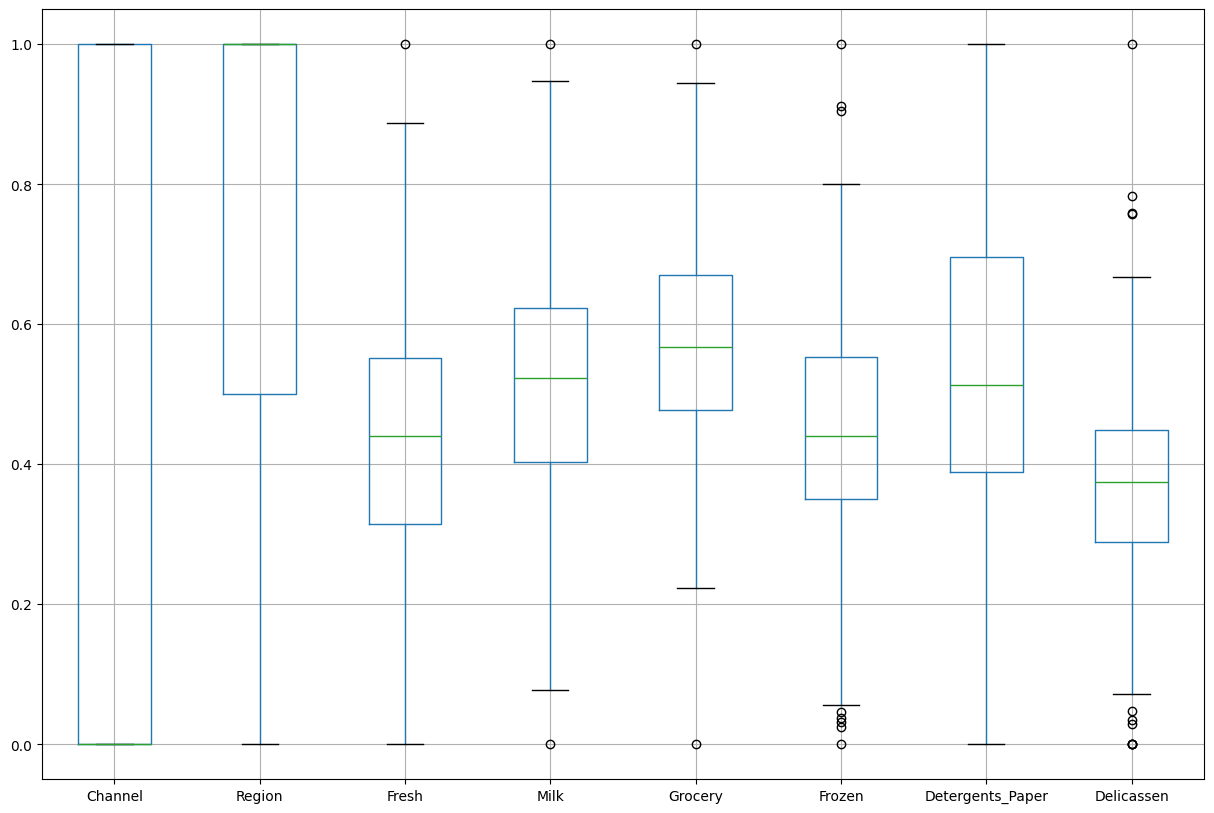

In [9]:
plt.figure(figsize=(15, 10))
df.boxplot()
plt.show()

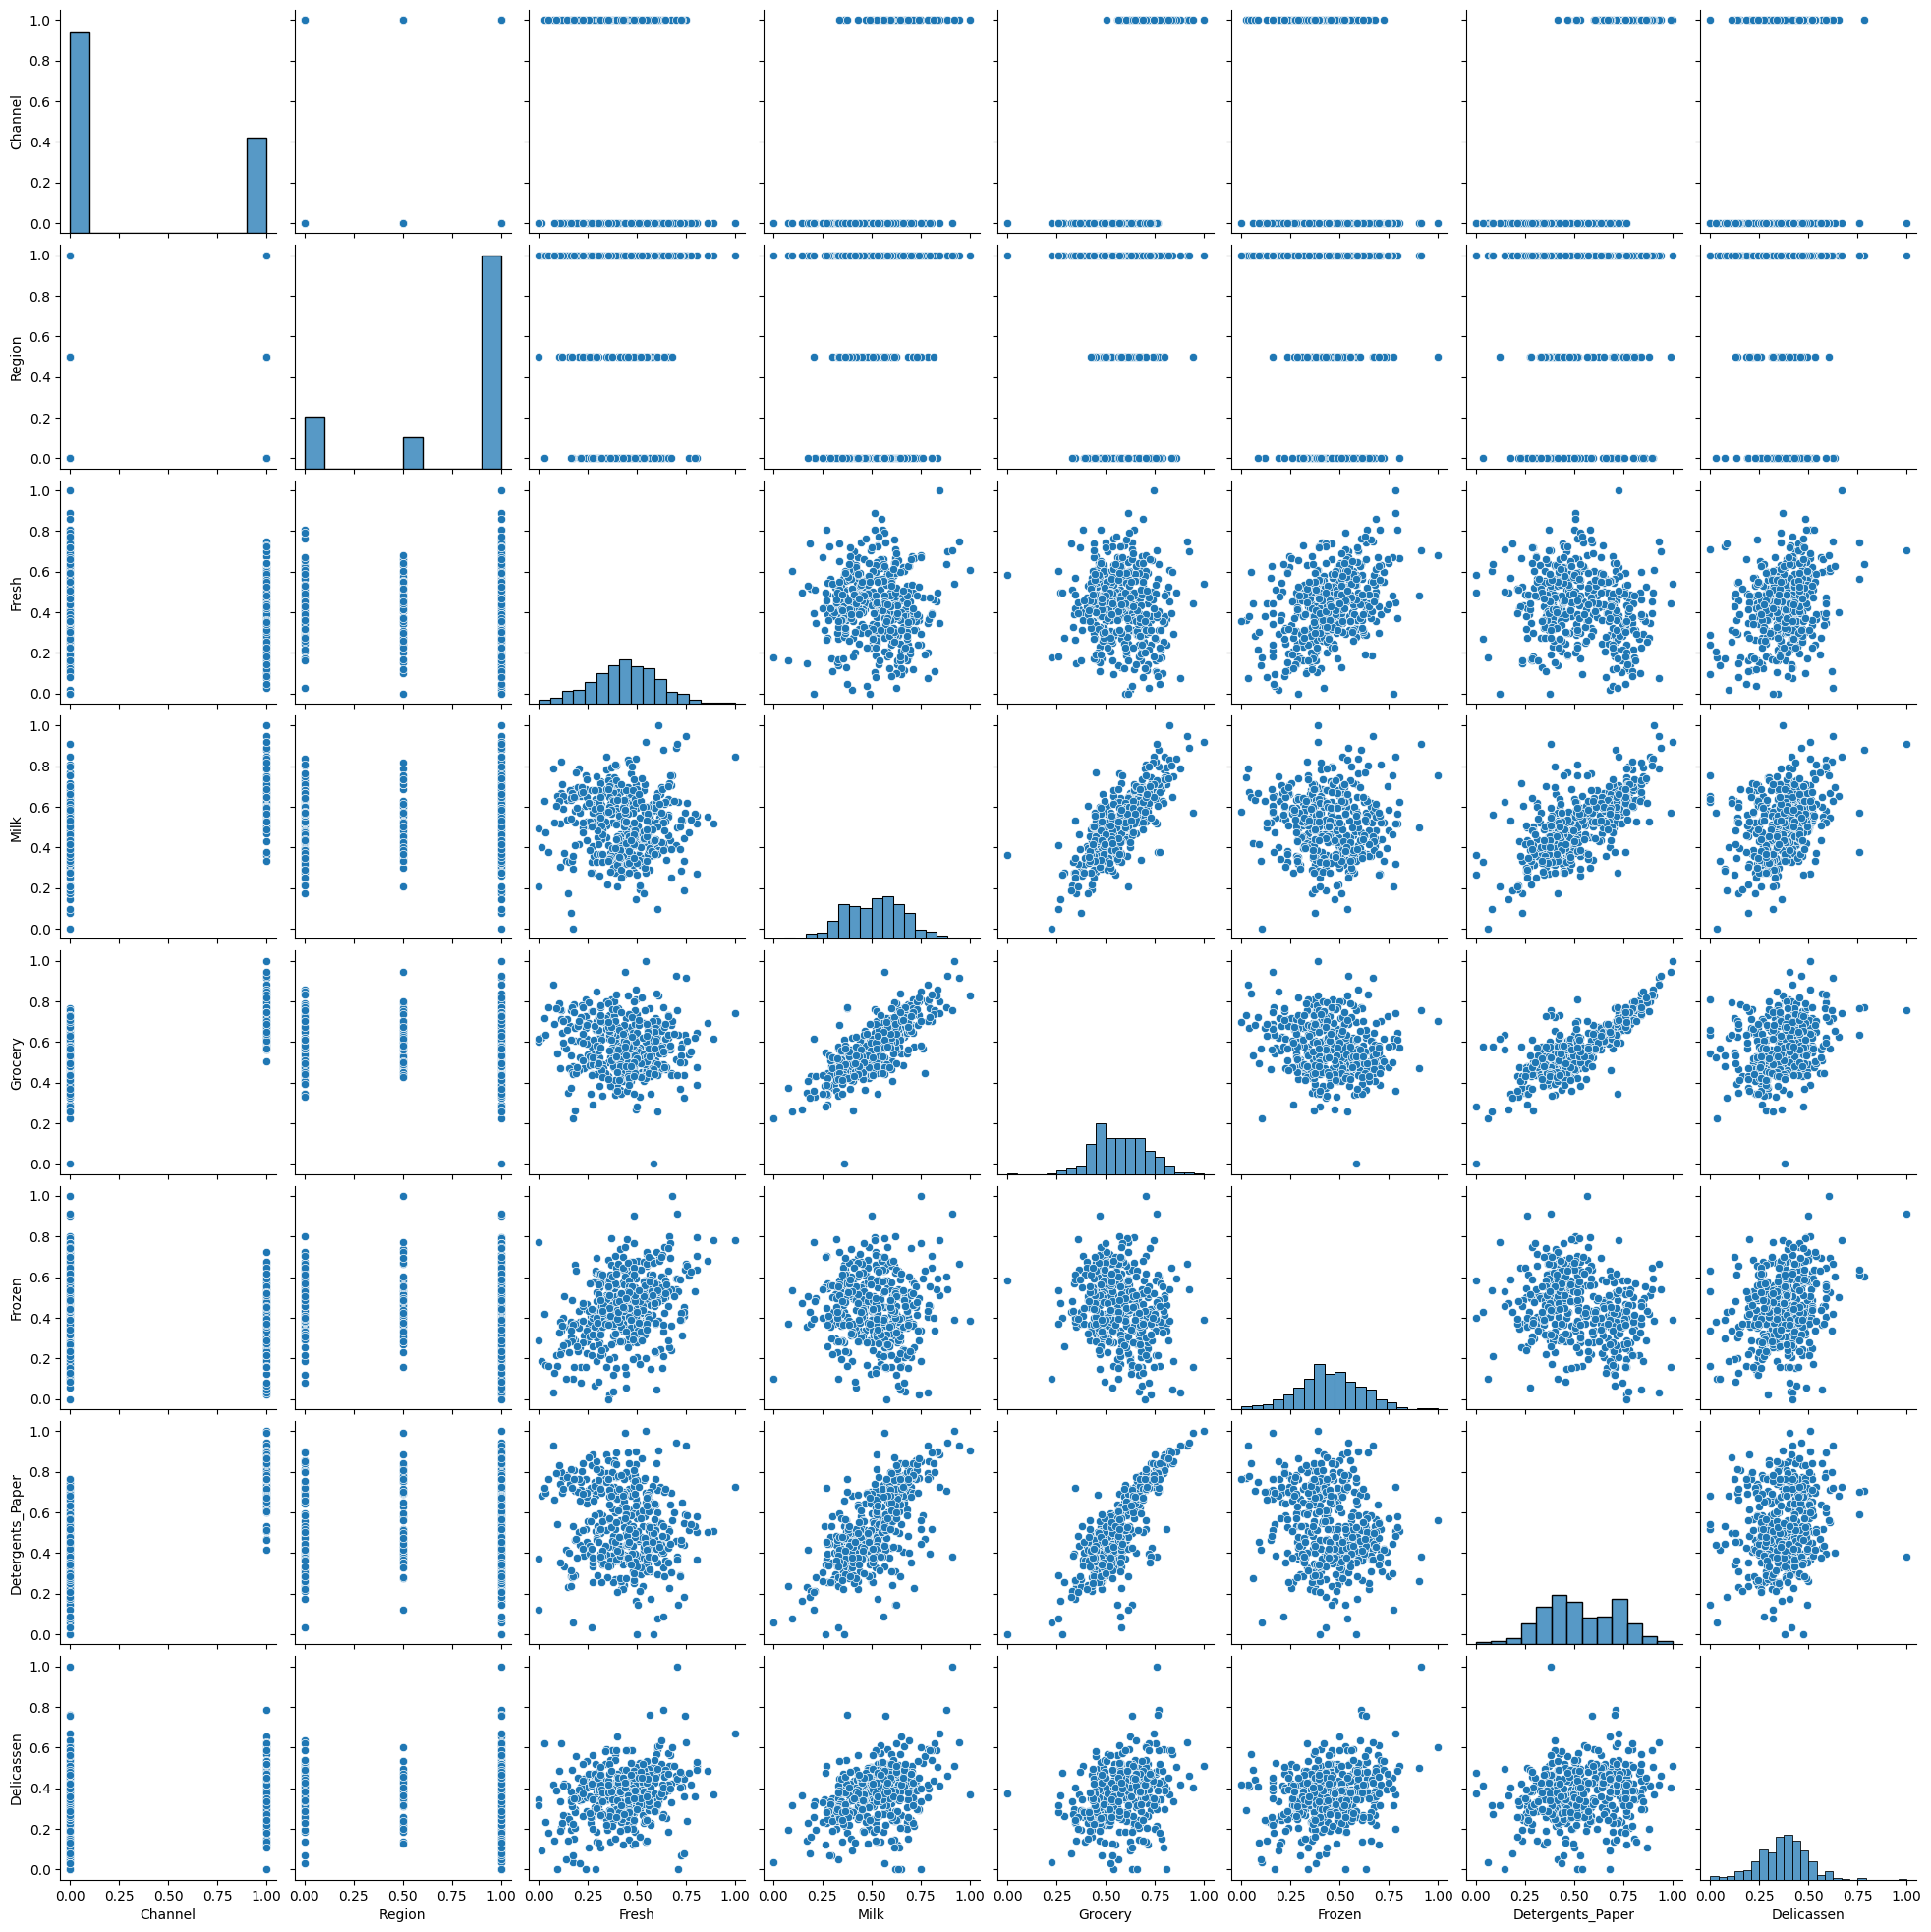

In [10]:
sns.pairplot(df)
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [4]:
results = pd.DataFrame(columns=["labels", "inertia", "silhouette_score"])

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(k, random_state=random_state)
    # estimator = kmeans.fit(df)
    # labels = kmeans.predict(df)
    labels = kmeans.fit_predict(df)
    # results.append((labels, estimator.inertia_, silhouette_score(df, labels)))
    results.loc[len(results)] = [
        labels,
        kmeans.inertia_,
        silhouette_score(df, labels)
    ]

results

NameError: name 'pd' is not defined

In [28]:
# k_range = list(range(2, 11))
# parameters_km = [{"n_clusters": k_range}]
# pg = ParameterGrid(parameters_km)
# print(list(pg))
# pg[1]

[{'n_clusters': 2}, {'n_clusters': 3}, {'n_clusters': 4}, {'n_clusters': 5}, {'n_clusters': 6}, {'n_clusters': 7}, {'n_clusters': 8}, {'n_clusters': 9}, {'n_clusters': 10}]


{'n_clusters': 3}

## 4. Plot __inertia__ and __silhouette score__ versus `k`

In [2]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    # plt.subplots() crea una nuova figura e uno o più assi (gli “spazi” in cui si disegnano grafici).
    #
    # Restituisce due oggetti:
    # - fig → l’oggetto Figure -> È la “pagina” o il contenitore generale che può contenere uno o più grafici.
    # - ax1 → l’oggetto Axes (plurale) -> È l’area effettiva in cui viene tracciato il grafico (assi X e Y, titoli, curve, ecc.).
    #    
    # fig serve per operazioni globali sulla figura, come: 
    # - impostare dimensioni (fig.set_size_inches(...))
    # - salvare l’immagine (fig.savefig("plot.png"))
    # - aggiungere più assi, ecc.
    #
    # ax1 serve per disegnare il grafico:
    # - ax1.plot(x, y)
    # - ax1.set_title("Titolo")
    # - ax1.set_xlabel("X")
    # - ax1.set_ylabel("Y")
    # 
    # NB: Axes non gestisce solo gli assi (che nome...), rappresenta tutto il riquadro del grafico invece
    #
    # se passo nrow ed ncol: fig, ax = plt.subplots(2, 2)
    # ax diventa un array di Axes (in questo caso 2x2), ognuno dei quali mi rappresenta un riquadro in qui disegnare il mio plot
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color) # modifica lo stile delle tacche dell'asse
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # sistema automaticamente margini e padding degli elementi per evitare sovrapposizioni
    plt.show()

In [3]:
two_plots(
    x=k_range,
    y1=inertias_km,
    y2=silhouette_scores_km,
    xlabel='Number of clusters',
    y1label='Inertias',
    y2label='Silhouette scores'
)

NameError: name 'k_range' is not defined

## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

Ricorda che vogliamo scegliere l'elbow point con il silhouette score maggiore e la distorsion minore

We will choose k=4

In [31]:
kmeans = KMeans(4, random_state=random_state)
labels = kmeans.fit_predict(df)
kmeans.inertia_, silhouette_score(df, labels)

(54.49187342996634, 0.49362944778631657)

Show the distribution of samples in the clusters with a pie chart

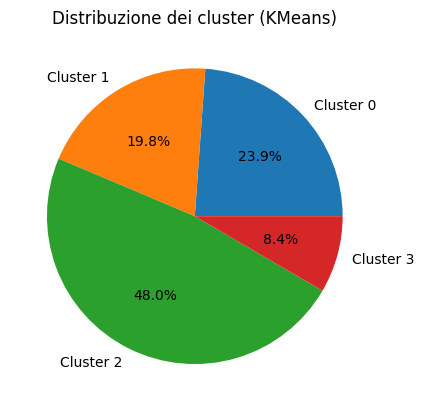

array([0, 1, 2, 3], dtype=int32)

In [40]:
# Un buon esperimento è quello di vedere come cambia la distribuzione se non facciamo preprocessing
import matplotlib.pyplot as plt
import pandas as pd


# conteggio delle occorrenze per ogni cluster
counts = pd.Series(labels).value_counts().sort_index()

# pie chart
plt.pie(
    counts,
    labels=[f"Cluster {i}" for i in np.unique(labels)],
    autopct='%1.1f%%', # percentuali delle fette
)
plt.title("Distribuzione dei cluster (KMeans)")
plt.show()

In [30]:
### mostriamo anche il risultato di plot_silhouette_w_mean.py
import plot_silhouette_w_mean

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Additional tasks
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results